## Setup and Imports

In [1]:
import math
import keras
import keras_cv
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

2023-06-28 06:30:33.723748: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 06:30:34.217573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops

## Dataset

In [2]:
# Dataset hyperparameters
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
NUM_CLASSES = 10

# Algorithm hyperparameterCLASSIFICATION_AUGMENTATIONABELED_BATCH_SIZE = 1024
LABELED_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
WIDTH = 128
TEMPERATURE = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
CONTRASTIVE_AUGMENTATION = {
    "min_area": 0.25,
    "brightness": keras_cv.UniformFactorSampler(lower=-0.6, upper=0.6),
    "jitter": keras_cv.UniformFactorSampler(lower=-0.2, upper=0.2),
}
CLASSIFICATION_AUGMENTATION = {
    "min_area": 0.75,
    "brightness": keras_cv.UniformFactorSampler(lower=-0.3, upper=0.3),
    "jitter": keras_cv.UniformFactorSampler(lower=-0.1, upper=0.1),
}

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def prepare_dataset():
    unlabeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="unlabelled", as_supervised=True)
        .map(lambda image, label: image, num_parallel_calls=AUTOTUNE)
        .shuffle(buffer_size=2 * UNLABELED_BATCH_SIZE)
        .batch(UNLABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    labeled_train_dataset = (
        tfds.load("stl10", data_dir="dataset", split="train", as_supervised=True)
        .shuffle(buffer_size=2 * LABELED_BATCH_SIZE)
        .batch(LABELED_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    test_dataset = (
        tfds.load("stl10", data_dir="dataset", split="test", as_supervised=True)
        .batch(TEST_BATCH_SIZE, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    return unlabeled_train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
unlabeled_train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

2023-06-28 06:31:04.254489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38169 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


## Augmentation Pipeline

In [4]:
# Distorts the color distibutions of images
class RandomColorAffine(keras_cv.layers.BaseImageAugmentationLayer):
    def __init__(self, brightness, jitter, **kwargs):
        super().__init__(**kwargs)
        self.brightness = brightness
        self.jitter = jitter

    def augment_image(self, image, transformation=None, **kwargs):
        # Same for all colors
        brightness_scales = 1 + self.brightness(shape=(1, 1, 1))

        # Different for all colors
        jitter_matrices = self.jitter(shape=(1, 3, 3))

        color_transforms = (
            tf.eye(num_rows=3) * brightness_scales + jitter_matrices
        )
        image = tf.clip_by_value(tf.matmul(image, color_transforms), 0, 1)

        return image

In [5]:
# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
            keras_cv.layers.Rescaling(scale=1./255),
            keras_cv.layers.RandomFlip("horizontal"),
            keras_cv.layers.RandomTranslation(
                height_factor=zoom_factor/2,
                width_factor=zoom_factor/2,

            ),
            keras_cv.layers.RandomZoom(
                height_factor=(-zoom_factor, 0.0),
                width_factor=(-zoom_factor, 0.0),
            ),
            RandomColorAffine(brightness, jitter),
        ]
    )

2023-06-28 06:31:10.645258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [16]
	 [[{{node Placeholder/_3}}]]
2023-06-28 06:31:10.645808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [16]
	 [[{{node Placeholder/_1}}]]


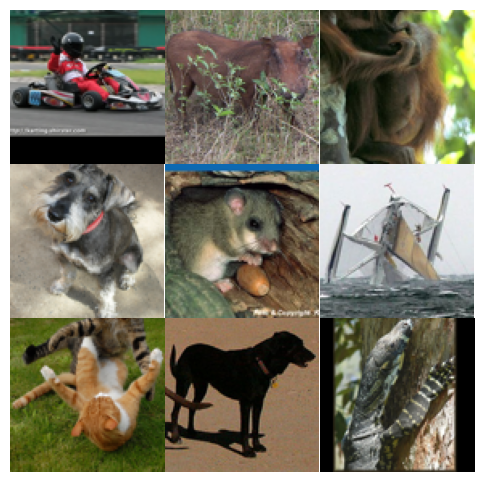

In [6]:
# Original Images
unlabeled_images = next(iter(unlabeled_train_dataset))
keras_cv.visualization.plot_image_gallery(
    images=unlabeled_images,
    value_range=(0, 255),
    rows=3,
    cols=3,
)

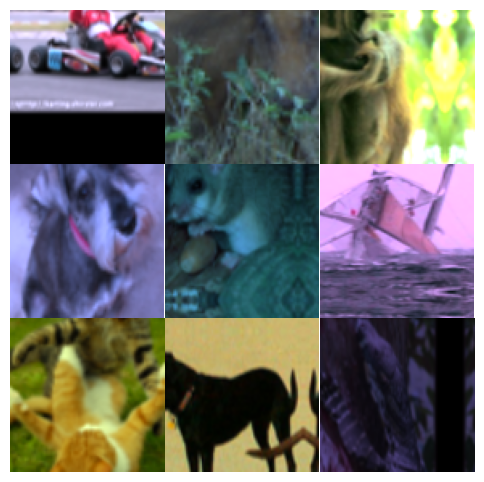

In [7]:
# Contrastive Augmentations
contrastive_augmenter = get_augmenter(**CONTRASTIVE_AUGMENTATION)
augmented_images = contrastive_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

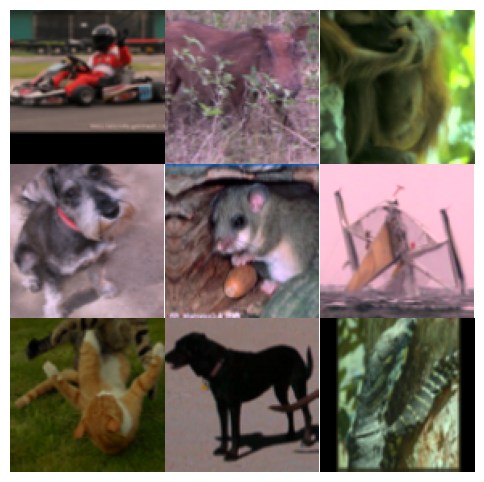

In [8]:
# Classification Augmentations
classification_augmenter = get_augmenter(**CLASSIFICATION_AUGMENTATION)
augmented_images = classification_augmenter(unlabeled_images)
keras_cv.visualization.plot_image_gallery(
    images=augmented_images,
    value_range=(0, 1),
    rows=3,
    cols=3,
)

## Encoder

In [9]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential([
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        keras_cv.models.ResNet18V2Backbone(include_rescaling=False),
        keras.layers.GlobalAveragePooling2D(name="avg_pool"),
    ],
        name="encoder",
)

## Supervised Baseline Model

In [10]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
        get_augmenter(**CLASSIFICATION_AUGMENTATION),
        get_encoder(),
        keras.layers.Dense(10),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=50, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/50


2023-06-28 06:31:50.687377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-06-28 06:31:50.687890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-06-28 06:31:54.128268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-06-28 06:31:56.835653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - ETA: 0s - loss: 2.3387 - acc: 0.1502

2023-06-28 06:32:00.262893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]
2023-06-28 06:32:00.263375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]


40/40 [==============================] - 12s 117ms/step - loss: 2.3387 - acc: 0.1502 - val_loss: 2.3364 - val_acc: 0.1000
Epoch 2/50
40/40 [==============================] - 2s 49ms/step - loss: 2.1658 - acc: 0.2098 - val_loss: 2.4268 - val_acc: 0.1000
Epoch 3/50
40/40 [==============================] - 2s 49ms/step - loss: 2.0289 - acc: 0.2590 - val_loss: 2.5113 - val_acc: 0.1004
Epoch 4/50
40/40 [==============================] - 2s 49ms/step - loss: 1.9318 - acc: 0.2902 - val_loss: 2.5745 - val_acc: 0.1415
Epoch 5/50
40/40 [==============================] - 2s 49ms/step - loss: 1.8439 - acc: 0.3196 - val_loss: 2.6088 - val_acc: 0.1548
Epoch 6/50
40/40 [==============================] - 2s 48ms/step - loss: 1.7643 - acc: 0.3502 - val_loss: 2.6163 - val_acc: 0.1517
Epoch 7/50
40/40 [==============================] - 2s 49ms/step - loss: 1.7229 - acc: 0.3600 - val_loss: 2.6072 - val_acc: 0.1475
Epoch 8/50
40/40 [==============================] - 2s 48ms/step - loss: 1.6752 - acc: 0.375

## Self-supervised model for contrastive pretraining

In [11]:
class SimCLRTrainer(keras_cv.training.ContrastiveTrainer):
    def __init__(self, encoder, augmenter, projector, probe=None, **kwargs):
        super().__init__(
            encoder=encoder,
            augmenter=augmenter,
            projector=projector,
            probe=probe,
            **kwargs,
        )

In [12]:
simclr_pre_trainer = SimCLRTrainer(
    encoder=get_encoder(),
    augmenter=get_augmenter(**CONTRASTIVE_AUGMENTATION),
    projector=keras.Sequential(
        [
            keras.layers.Dense(WIDTH, activation="relu"),
            keras.layers.Dense(WIDTH),
            keras.layers.BatchNormalization(),
        ],
        name="projector",
    ),
)

simclr_pre_trainer.compile(
    encoder_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    encoder_loss=keras_cv.losses.SimCLRLoss(
        temperature=TEMPERATURE,
    ),
)

In [13]:
pretraining_history = simclr_pre_trainer.fit(
    unlabeled_train_dataset,
    epochs=50,
)

2023-06-28 06:35:06.568012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-06-28 06:35:06.568754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype resource
	 [[{{node Placeholder/_34}}]]


Epoch 1/50
98/98 [==============================] - 72s 583ms/step - loss: 15.9064
Epoch 2/50
98/98 [==============================] - 61s 590ms/step - loss: 14.6964
Epoch 3/50
98/98 [==============================] - 63s 608ms/step - loss: 14.0129
Epoch 4/50
98/98 [==============================] - 65s 629ms/step - loss: 13.4701
Epoch 5/50
98/98 [==============================] - 61s 592ms/step - loss: 12.9560
Epoch 6/50
98/98 [==============================] - 61s 590ms/step - loss: 12.5095
Epoch 7/50
98/98 [==============================] - 61s 591ms/step - loss: 12.0909
Epoch 8/50
98/98 [==============================] - 61s 590ms/step - loss: 11.7116
Epoch 9/50
98/98 [==============================] - 61s 591ms/step - loss: 11.3551
Epoch 10/50
98/98 [==============================] - 61s 591ms/step - loss: 11.0258
Epoch 11/50
98/98 [==============================] - 61s 589ms/step - loss: 10.7271
Epoch 12/50
98/98 [==============================] - 61s 590ms/step - loss: 10.4558
E

## Fine tuning

In [14]:
simclr_fine_tuner = SimCLRTrainer(
    encoder=simclr_pre_trainer.encoder,
    augmenter=get_augmenter(**CLASSIFICATION_AUGMENTATION),
    projector=simclr_pre_trainer.projectors[0],
    probe=keras.layers.Dense(NUM_CLASSES),
)

simclr_fine_tuner.compile(
    encoder_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    encoder_loss=keras_cv.losses.SimCLRLoss(
        temperature=TEMPERATURE
    ),
    probe_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    probe_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    probe_metrics=[keras.metrics.SparseCategoricalCrossentropy(name="probe_accuracy")]
)

In [17]:
finetuning_history = simclr_fine_tuner.fit(
    labeled_train_dataset,
    epochs=50,
)

2023-06-28 07:31:49.265698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-06-28 07:31:49.266317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype resource
	 [[{{node Placeholder/_33}}]]


Epoch 1/50
40/40 [==============================] - 3s 72ms/step - loss: 0.1658 - probe_loss: 11.5058 - probe_accuracy: 2.3026
Epoch 2/50
40/40 [==============================] - 3s 72ms/step - loss: 0.1647 - probe_loss: 11.9443 - probe_accuracy: 2.3026
Epoch 3/50
40/40 [==============================] - 3s 71ms/step - loss: 0.1663 - probe_loss: 12.1328 - probe_accuracy: 2.3026
Epoch 4/50
40/40 [==============================] - 4s 77ms/step - loss: 0.1647 - probe_loss: 11.9328 - probe_accuracy: 2.3026
Epoch 5/50
40/40 [==============================] - 3s 71ms/step - loss: 0.1667 - probe_loss: 11.3814 - probe_accuracy: 2.3026
Epoch 6/50
40/40 [==============================] - 3s 71ms/step - loss: 0.1605 - probe_loss: 11.2664 - probe_accuracy: 2.3026
Epoch 7/50
40/40 [==============================] - 3s 70ms/step - loss: 0.1631 - probe_loss: 11.2995 - probe_accuracy: 2.3026
Epoch 8/50
40/40 [==============================] - 3s 72ms/step - loss: 0.1580 - probe_loss: 10.9364 - probe_a

In [20]:
fine_tuned_model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
    simclr_fine_tuner.encoder,
    simclr_fine_tuner.probe,
])


fine_tuned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
loss, accuracy = fine_tuned_model.evaluate(test_dataset)

print(f"{loss=:0.4f}")
print(f"{accuracy=:0.4f}")

63/63 [==============================] - 1s 10ms/step - loss: 8.6382 - acc: 0.3332
loss=8.6382
accuracy=0.3332
